In [197]:
import mne
import sys
import numpy as np
from matplotlib import pyplot as plt
from mne_bids import BIDSPath, read_raw_bids

In [198]:
# helper functions

def load_data(bids_root="/Users/jan/Documents/git/ds003846", subject_id="02", session="EMS"):
    """Loads EEG data for the given subject and session."""
    bids_path = BIDSPath(subject=subject_id, task="PredictionError", session=session,
                        datatype='eeg', suffix='eeg',
                        root=bids_root)

    # Read the file
    raw = read_raw_bids(bids_path)
    raw.info

    # Plot electrode positions
    #raw.plot_sensors(show_names=True)
    
    return raw


def remove_bad_channels(raw, subject_id):
    """Remove bad channels from raw data based on their descriptions and inspections."""
    bad_channels_list = {
        2: [4, 16],
        3: [9, 10, 55, 60],
        4: [41],
        5: [1, 33, 41, 42],
        6: [9, 16, 43, 46, 10, 14],
        7: [17, 32, 49],
        8: [41, 42, 62, 63, 9, 17, 55],
        9: [12, 41, 46],
        10: [42, 45, 41, 33, 17],
        11: [22],
        12: [2, 22, 31, 64],
        13: [7, 16, 40, 46, 48],
        14: [2, 3, 7, 16, 28],
        15: [5, 6, 12, 33, 34, 46],
        16: [28, 29, 41, 45, 60],
        17: [1, 2, 3, 22, 28, 36],
        18: [15, 17, 26, 30, 45],
        19: [15, 22, 26, 46, 55, 59, 60],
        20: [2, 8, 11, 36, 62]
    }

    bad_channels = bad_channels_list.get(subject_id, [])
    raw.info['bads'] = [raw.ch_names[ch] for ch in bad_channels]
    print(raw.info['bads'])


def filtering_referencing(data):
    """Applies filtering and re-referencing to the data."""
    # Remove line noise
    data = data.load_data().copy().notch_filter(freqs=[50, 150])

    # Apply bandpass filter
    data = data.filter(l_freq=0.1, h_freq=125.0)

    # Resample with 250 Hz for less data size
    data = data.copy().resample(sfreq=250)

    # Add reference channels
    data.add_reference_channels(['FCz'])
    
    # Set montage (aka electrode positions)
    montage = mne.channels.make_standard_montage('standard_1020')
    data.set_montage(montage)

    # Re-reference to average
    data = data.set_eeg_reference('average')
    
    return data


def apply_ica_eyes(data):
    """Applies ICA to remove eye movements."""
    # Remove artifacts with ICA
    ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter="auto")
    ica.fit(data)

    # Check with Fp2 channel as EOG (electrooculography aka eye movement channel)
    eog_inds, eog_scores = ica.find_bads_eog(data, ch_name='Fp2')
    ica.plot_scores(eog_scores)
    ica.plot_properties(data, picks=eog_inds)

    ica.plot_sources(data, start=60)
    ica.plot_components()
    
    # Remove ICA components
    # Remove the eye movement components
    ica.exclude = eog_inds
    data = ica.apply(data)
    
    return data


def make_erp(data, condition="conflict"):
    evts, evts_dict = mne.events_from_annotations(data)
    #print(evts, evts_dict)
    
    wanted_keys = [e for e in evts_dict.keys() if f"normal_or_conflict:{condition}" in e and "box:touched" in e]
    evts_dict_stim = dict((k, evts_dict[k]) for k in wanted_keys if k in evts_dict)
    #print(evts_dict_stim)
    
    # Epoching
    epochs = mne.Epochs(data, evts, evts_dict_stim, tmin=-0.3, tmax=0.7, event_repeated='drop', baseline=None)
    
    # Correc time
    epochs = epochs.load_data().shift_time(-0.063)
    
    # Apply final bandpass filter
    epochs = epochs.copy().filter(l_freq=0.5, h_freq=35.0)

    epochs.average().copy().pick(['FCz']).plot()
    
    return epochs.average().copy().pick(['FCz'])


def make_erp_plot(normal_data, conflict_data):
    colors = {"Visual": "C0",
        "Vibro": "C2",
        "EMS": "C1"
    }    
    
    mne.viz.plot_compare_evokeds(
        normal_data,
        picks="FCz",
        time_unit="ms",
        colors=colors,
        title="Normal (FCz)"
    )
    
    mne.viz.plot_compare_evokeds(
        conflict_data,
        picks="FCz",
        time_unit="ms",
        colors=colors,
        title="Conflict (FCz)"
    )

# Pipeline

Session: Visual
Extracting parameters from /Users/jan/Documents/git/ds003846/sub-02/ses-Visual/eeg/sub-02_ses-Visual_task-PredictionError_eeg.vhdr...
Setting channel info structure...
Reading events from /Users/jan/Documents/git/ds003846/sub-02/ses-Visual/eeg/sub-02_ses-Visual_task-PredictionError_events.tsv.
Reading channel info from /Users/jan/Documents/git/ds003846/sub-02/ses-Visual/eeg/sub-02_ses-Visual_task-PredictionError_channels.tsv.


/var/folders/bb/xxm_9vsj1w9c1jg8lvn4kll00000gn/T/ipykernel_2987/1397405393.py:10: RuntimeWarning: Unable to map the following column(s) to to MNE:
cap_size: 58
block_1: Visual
block_2: Visual + Vibro
block_3: Visual + Vibro + EMS
  raw = read_raw_bids(bids_path)


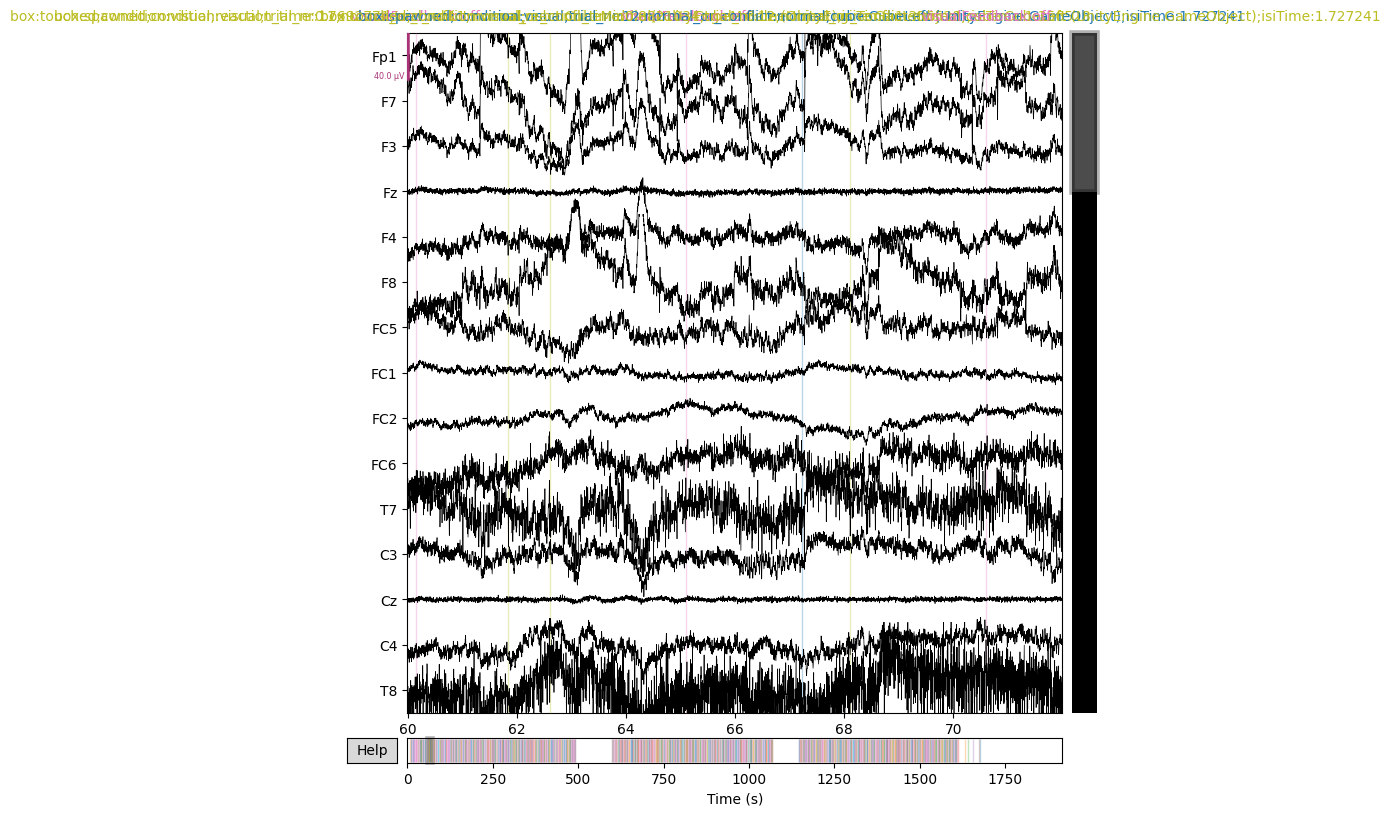

Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Need more than one channel to make topography for eeg. Disabling interactivity.
['Fz', 'TP9']
Reading 0 ... 959079  =      0.000 ...  1918.184 secs...


/var/folders/bb/xxm_9vsj1w9c1jg8lvn4kll00000gn/T/ipykernel_2987/2655731138.py:13: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  data.copy().pick(["Cz"]).compute_psd().plot()
/Users/jan/miniforge3/envs/eeg/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 125.00 Hz
- Upper transition bandwidth: 31.25 Hz (-6 dB cutoff frequency: 140.62 Hz)
- Filter length: 16501 samples (33.002 s)

EEG channe

/var/folders/bb/xxm_9vsj1w9c1jg8lvn4kll00000gn/T/ipykernel_2987/1397405393.py:64: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  data.set_montage(montage)


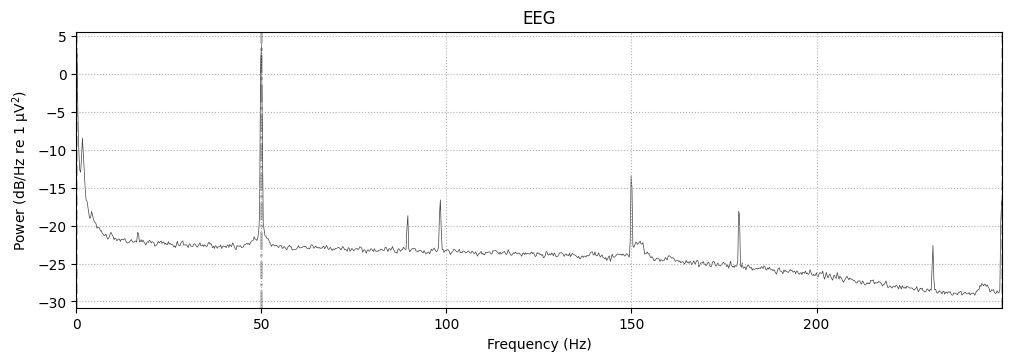

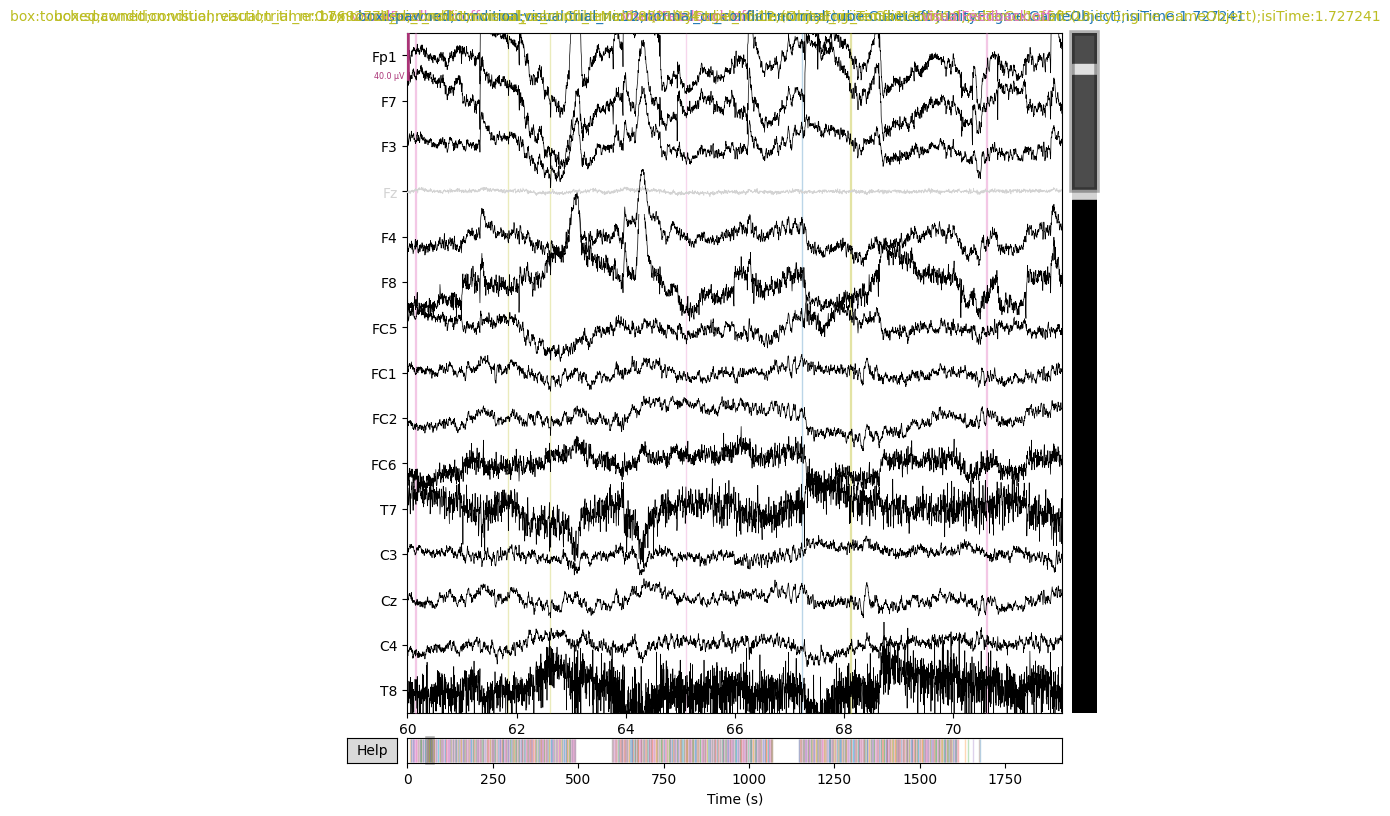

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).
Need more than one channel to make topography for eeg. Disabling interactivity.
Fitting ICA to data using 62 channels (please be patient, this may take a while)


/Users/jan/miniforge3/envs/eeg/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Selecting by number: 20 components
Fitting ICA took 3.8s.
Using EOG channel: Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition

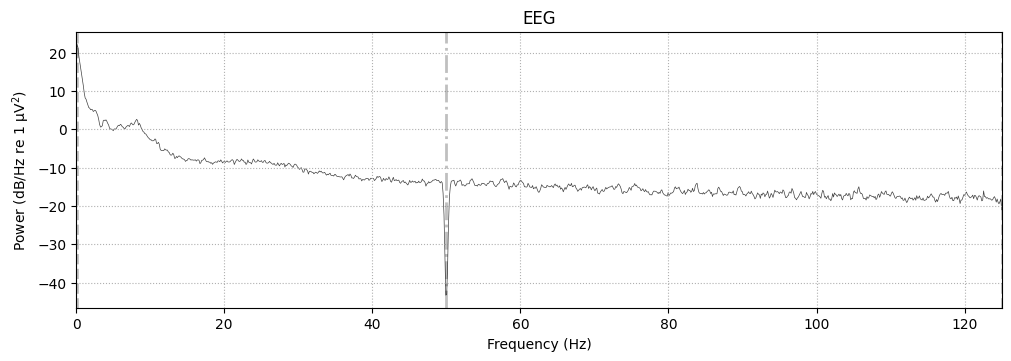

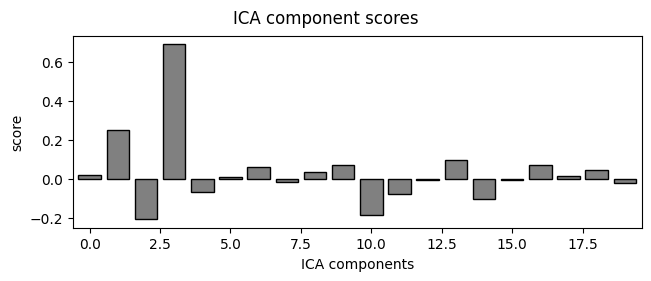

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
959 matching events found
No baseline correction applied
0 projection items activated


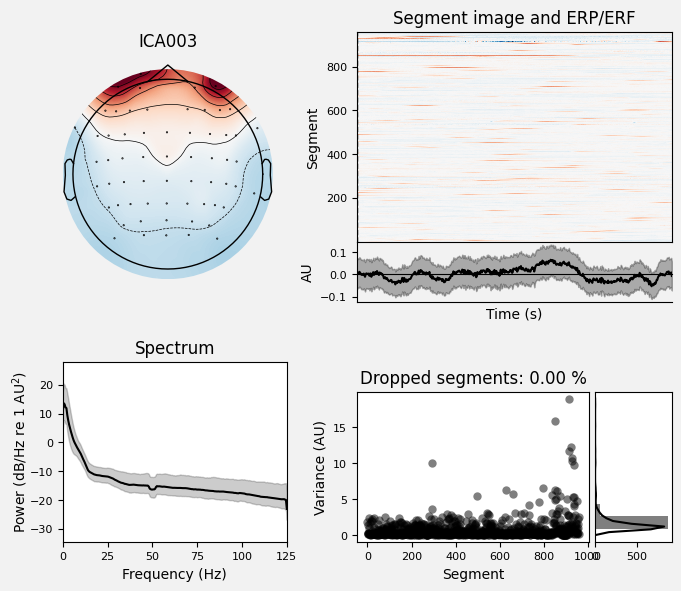

Creating RawArray with float64 data, n_channels=21, n_times=479546
    Range : 0 ... 479545 =      0.000 ...  1918.180 secs
Ready.


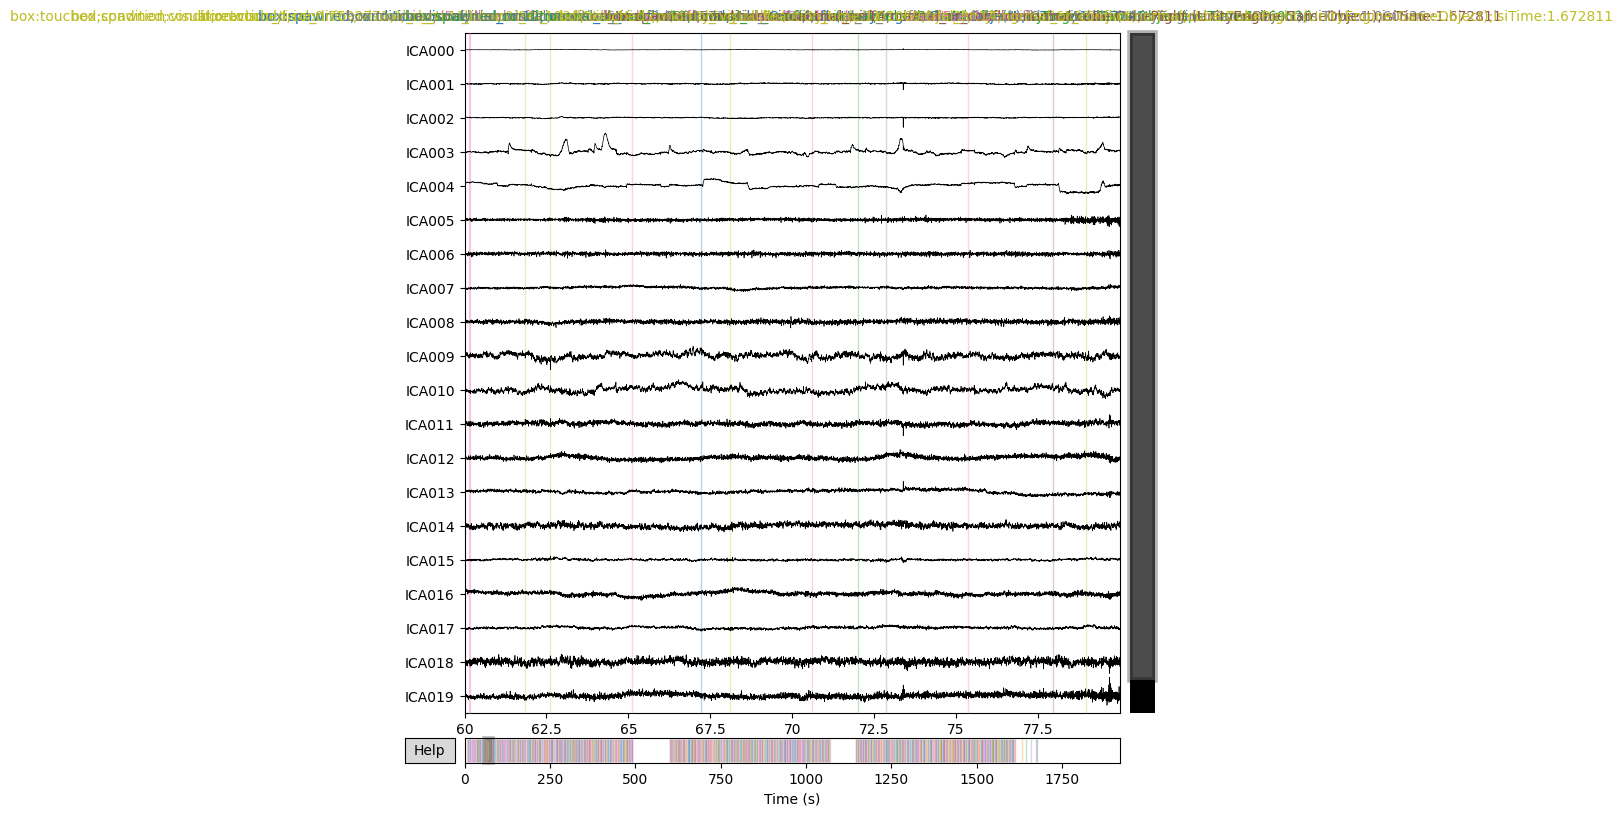

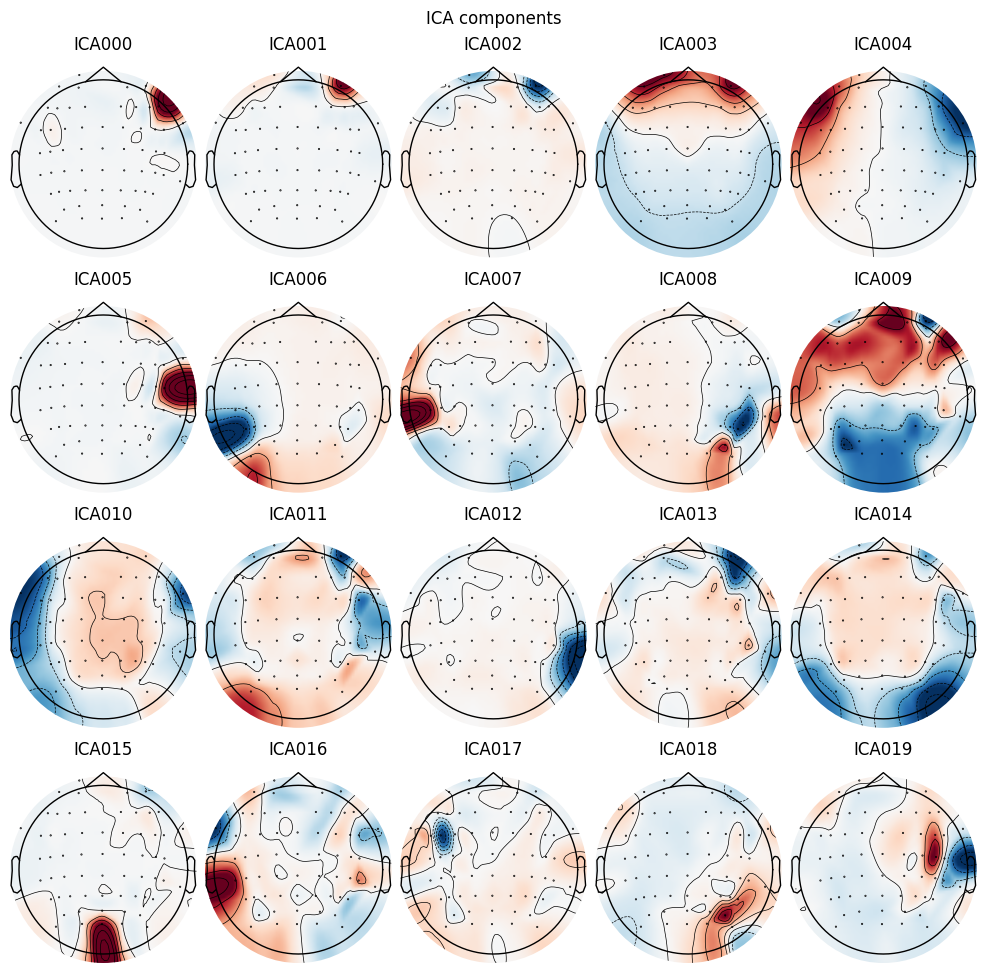

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 62 PCA components


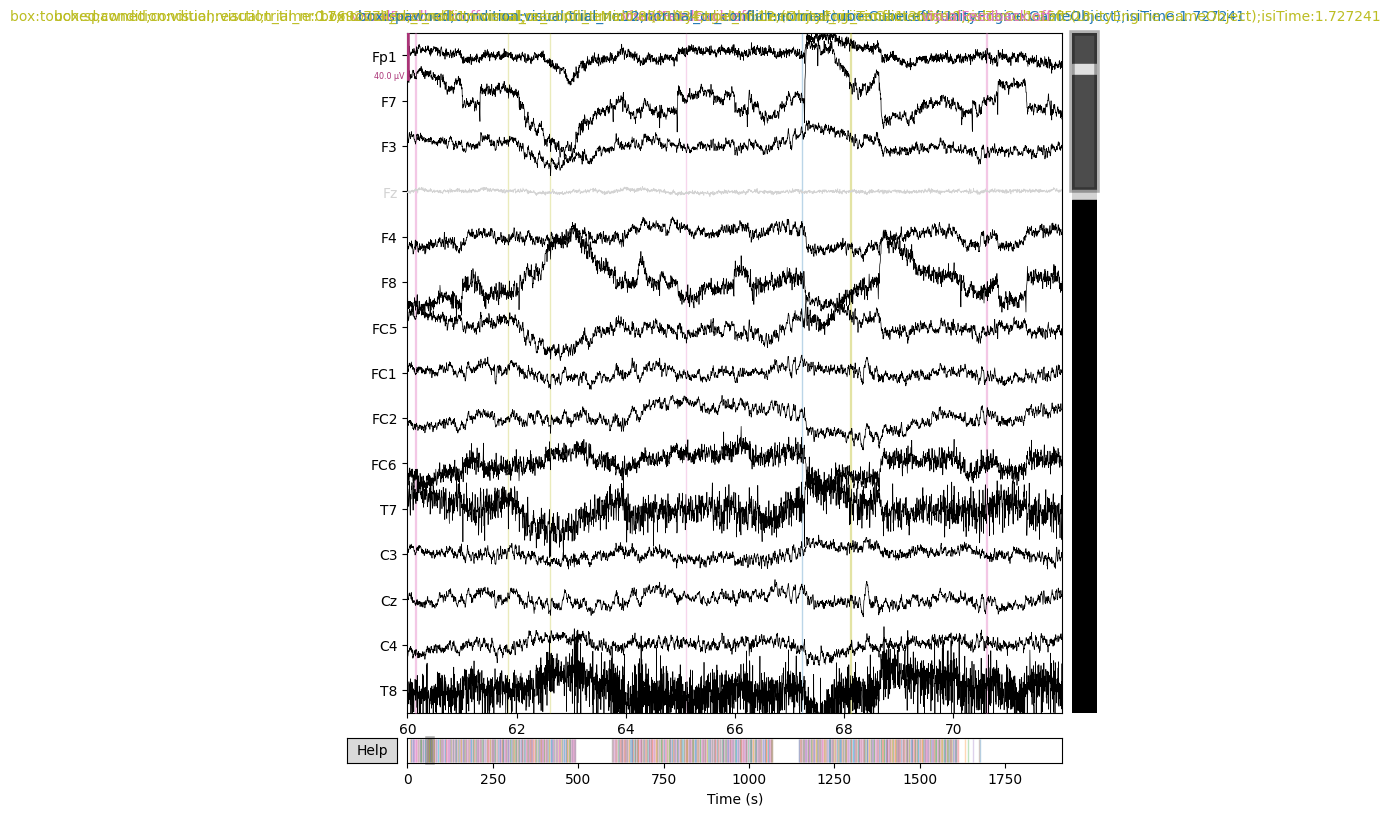

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).
Need more than one channel to make topography for eeg. Disabling interactivity.
Used Annotations descriptions: [np.str_('block:end;currentBlockNr:3;condition:visual;training:false'), np.str_('block:start;currentBlockNr:1;condition:visual;training:false'), np.str_('block:start;currentBlockNr:2;condition:visual;training:false'), np.str_('block:start;currentBlockNr:3;condition:visual;training:false'), np.str_('box:spawned;condition:visual;trial_nr:100;normal_or_conflict:conflict;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.777898'), np.str_('box:spawned;condition:visual;trial_nr:101;normal_or_conflict:normal;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.235522'), np.str_('box:spawned;condition:visual;trial_nr:102;normal_or_conflict:normal;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.278034'), np.str_('box:spawned;condition:visual;trial_nr:103;normal_or_conflict:normal;cube:CubeRight (UnityEngine.Ga

/Users/jan/miniforge3/envs/eeg/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/var/folders/bb/xxm_9vsj1w9c1jg8lvn4kll00000gn/T/ipykernel_2987/1397405393.py:109: RuntimeWarning: filter_length (1651) is longer than the signal (251), distortion is likely. Reduce filter length or filter a longer signal.
  epochs = epochs.copy().filter(l_freq=0.5, h_freq=35.0)


Need more than one channel to make topography for eeg. Disabling interactivity.


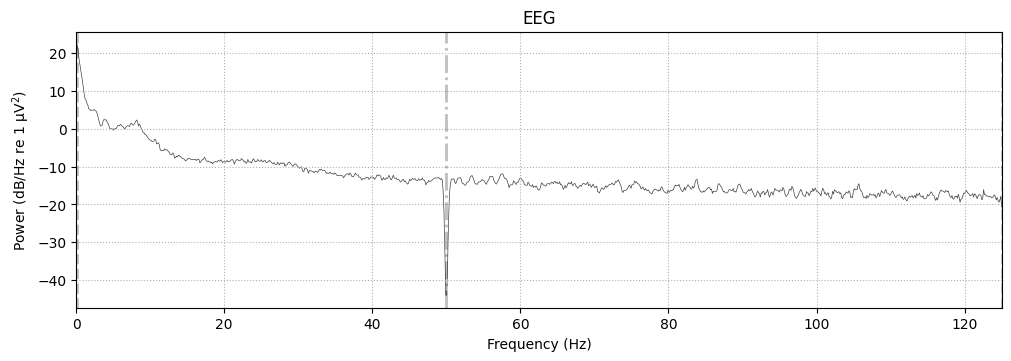

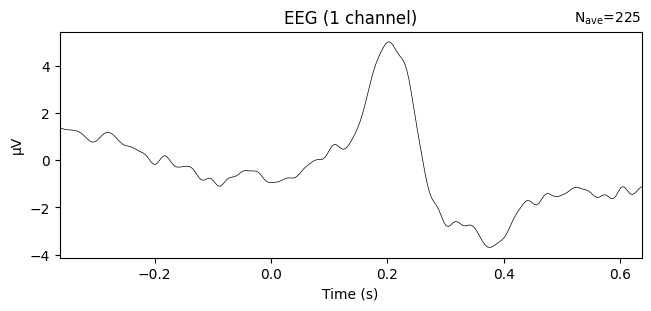

Used Annotations descriptions: [np.str_('block:end;currentBlockNr:3;condition:visual;training:false'), np.str_('block:start;currentBlockNr:1;condition:visual;training:false'), np.str_('block:start;currentBlockNr:2;condition:visual;training:false'), np.str_('block:start;currentBlockNr:3;condition:visual;training:false'), np.str_('box:spawned;condition:visual;trial_nr:100;normal_or_conflict:conflict;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.777898'), np.str_('box:spawned;condition:visual;trial_nr:101;normal_or_conflict:normal;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.235522'), np.str_('box:spawned;condition:visual;trial_nr:102;normal_or_conflict:normal;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.278034'), np.str_('box:spawned;condition:visual;trial_nr:103;normal_or_conflict:normal;cube:CubeRight (UnityEngine.GameObject);isiTime:1.271817'), np.str_('box:spawned;condition:visual;trial_nr:104;normal_or_conflict:normal;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.4

/var/folders/bb/xxm_9vsj1w9c1jg8lvn4kll00000gn/T/ipykernel_2987/1397405393.py:109: RuntimeWarning: filter_length (1651) is longer than the signal (251), distortion is likely. Reduce filter length or filter a longer signal.
  epochs = epochs.copy().filter(l_freq=0.5, h_freq=35.0)


Need more than one channel to make topography for eeg. Disabling interactivity.


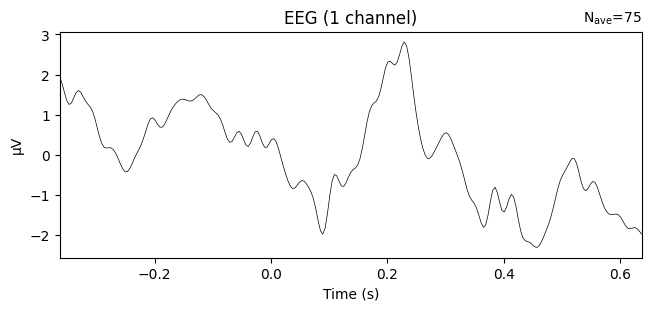

Session: Vibro
Extracting parameters from /Users/jan/Documents/git/ds003846/sub-02/ses-Vibro/eeg/sub-02_ses-Vibro_task-PredictionError_eeg.vhdr...
Setting channel info structure...
Reading events from /Users/jan/Documents/git/ds003846/sub-02/ses-Vibro/eeg/sub-02_ses-Vibro_task-PredictionError_events.tsv.
Reading channel info from /Users/jan/Documents/git/ds003846/sub-02/ses-Vibro/eeg/sub-02_ses-Vibro_task-PredictionError_channels.tsv.


/var/folders/bb/xxm_9vsj1w9c1jg8lvn4kll00000gn/T/ipykernel_2987/1397405393.py:10: RuntimeWarning: Unable to map the following column(s) to to MNE:
cap_size: 58
block_1: Visual
block_2: Visual + Vibro
block_3: Visual + Vibro + EMS
  raw = read_raw_bids(bids_path)


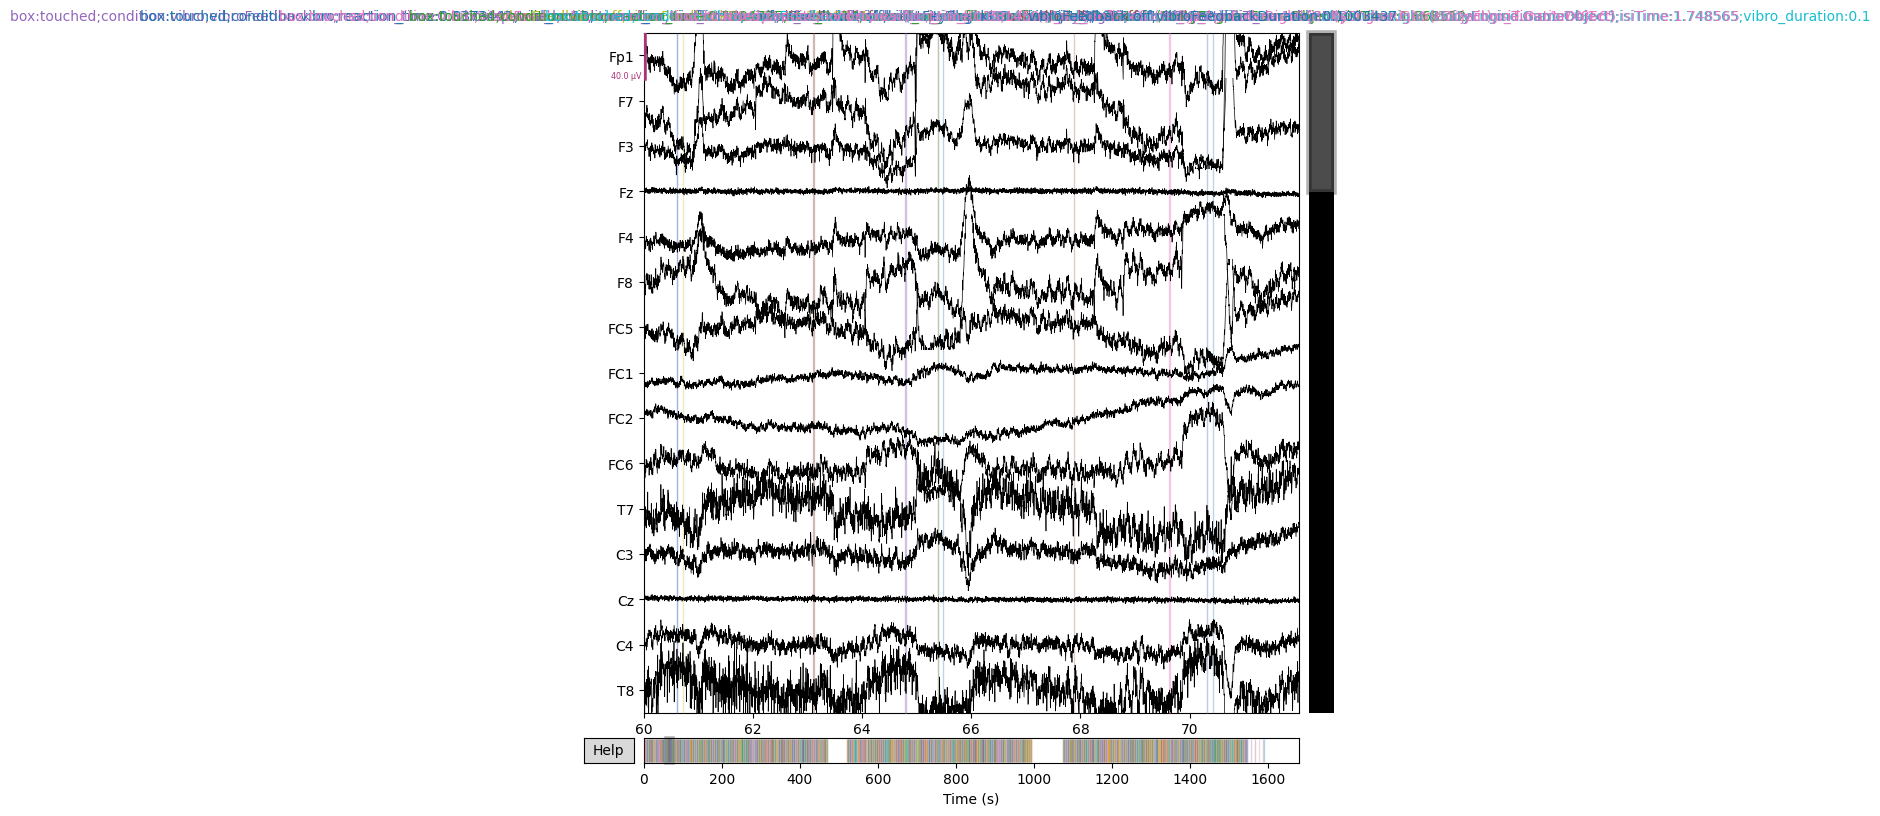

Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Need more than one channel to make topography for eeg. Disabling interactivity.
['Fz', 'TP9']
Reading 0 ... 838759  =      0.000 ...  1677.540 secs...


/var/folders/bb/xxm_9vsj1w9c1jg8lvn4kll00000gn/T/ipykernel_2987/2655731138.py:13: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  data.copy().pick(["Cz"]).compute_psd().plot()
/Users/jan/miniforge3/envs/eeg/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 125.00 Hz
- Upper transition bandwidth: 31.25 Hz (-6 dB cutoff frequency: 140.62 Hz)
- Filter length: 16501 samples (33.002 s)

EEG channe

/var/folders/bb/xxm_9vsj1w9c1jg8lvn4kll00000gn/T/ipykernel_2987/1397405393.py:64: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  data.set_montage(montage)


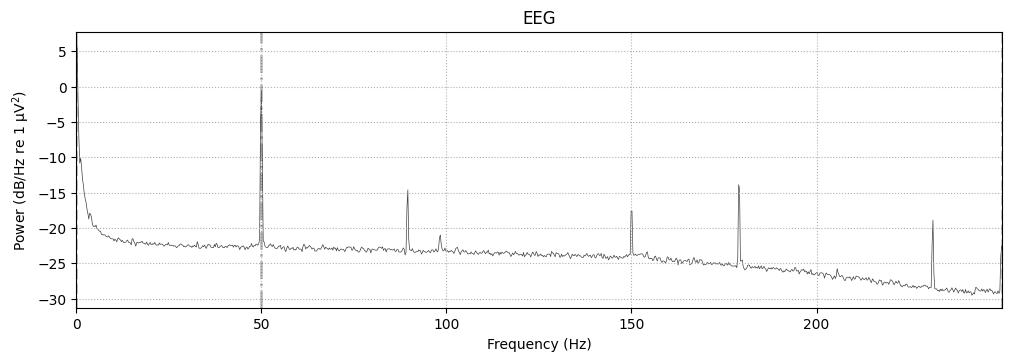

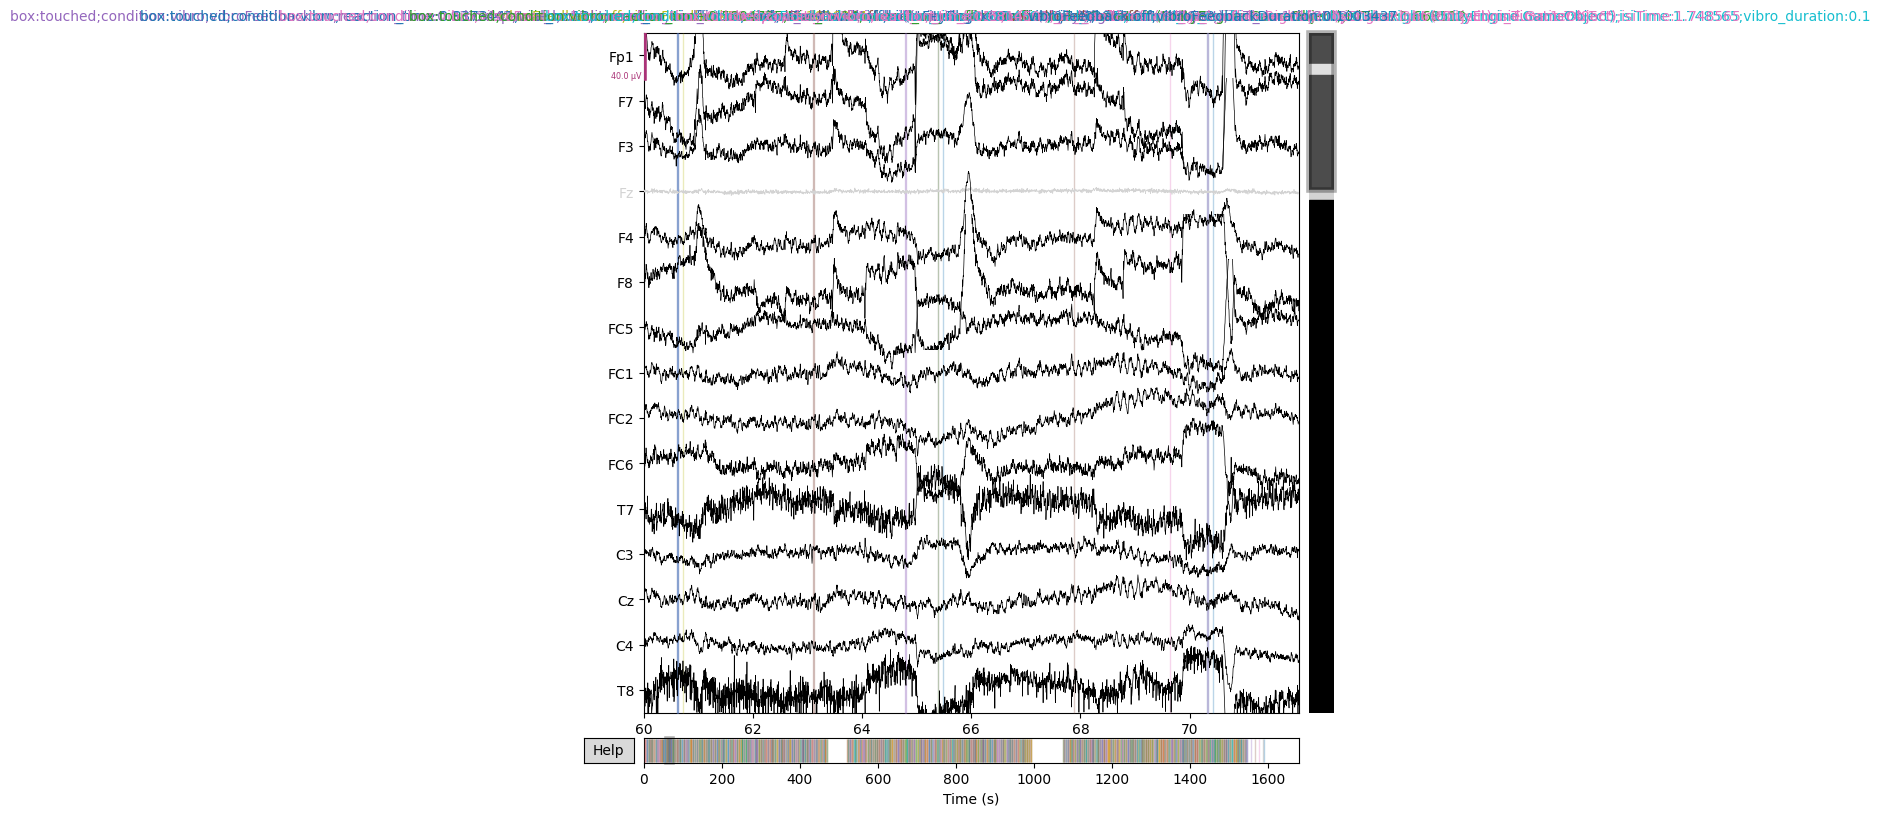

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).
Need more than one channel to make topography for eeg. Disabling interactivity.
Fitting ICA to data using 62 channels (please be patient, this may take a while)


/Users/jan/miniforge3/envs/eeg/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Selecting by number: 20 components
Fitting ICA took 4.3s.
Using EOG channel: Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition

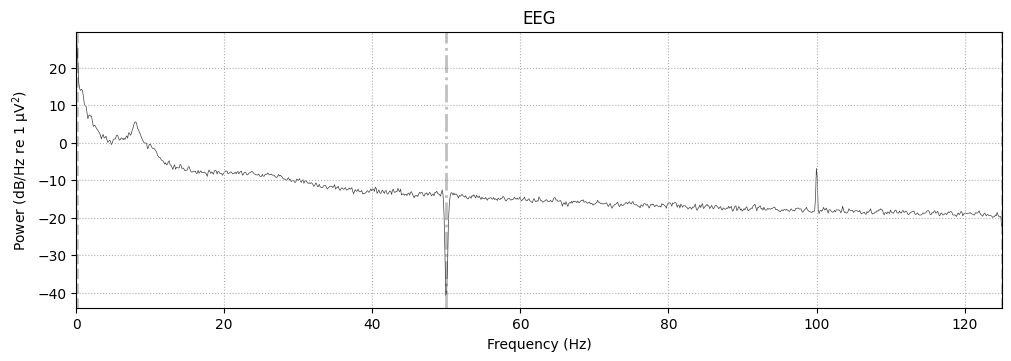

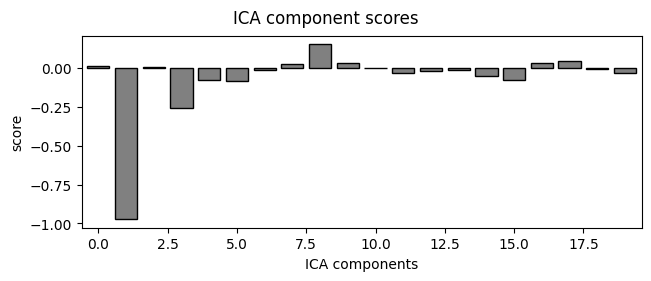

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
838 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
838 matching events found
No baseline correction applied
0 projection items activated


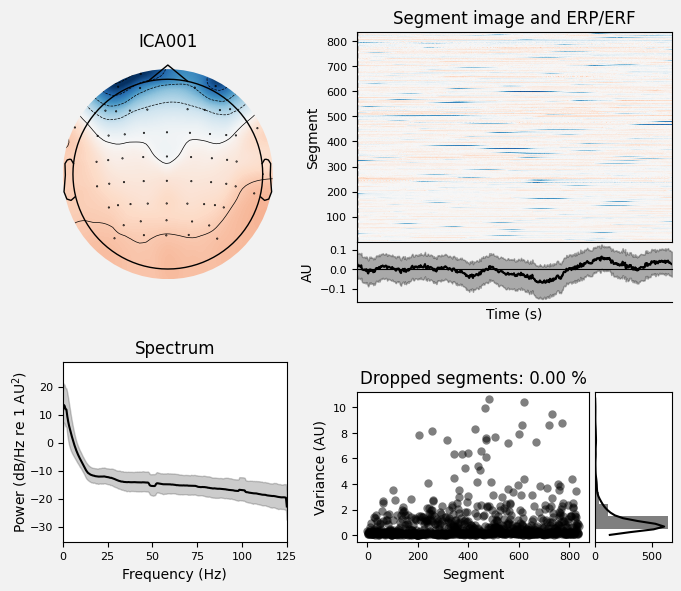

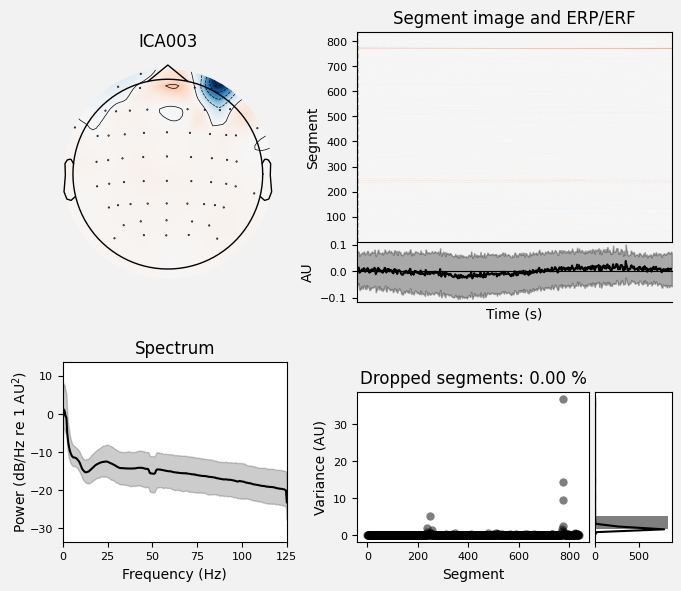

Creating RawArray with float64 data, n_channels=21, n_times=419386
    Range : 0 ... 419385 =      0.000 ...  1677.540 secs
Ready.


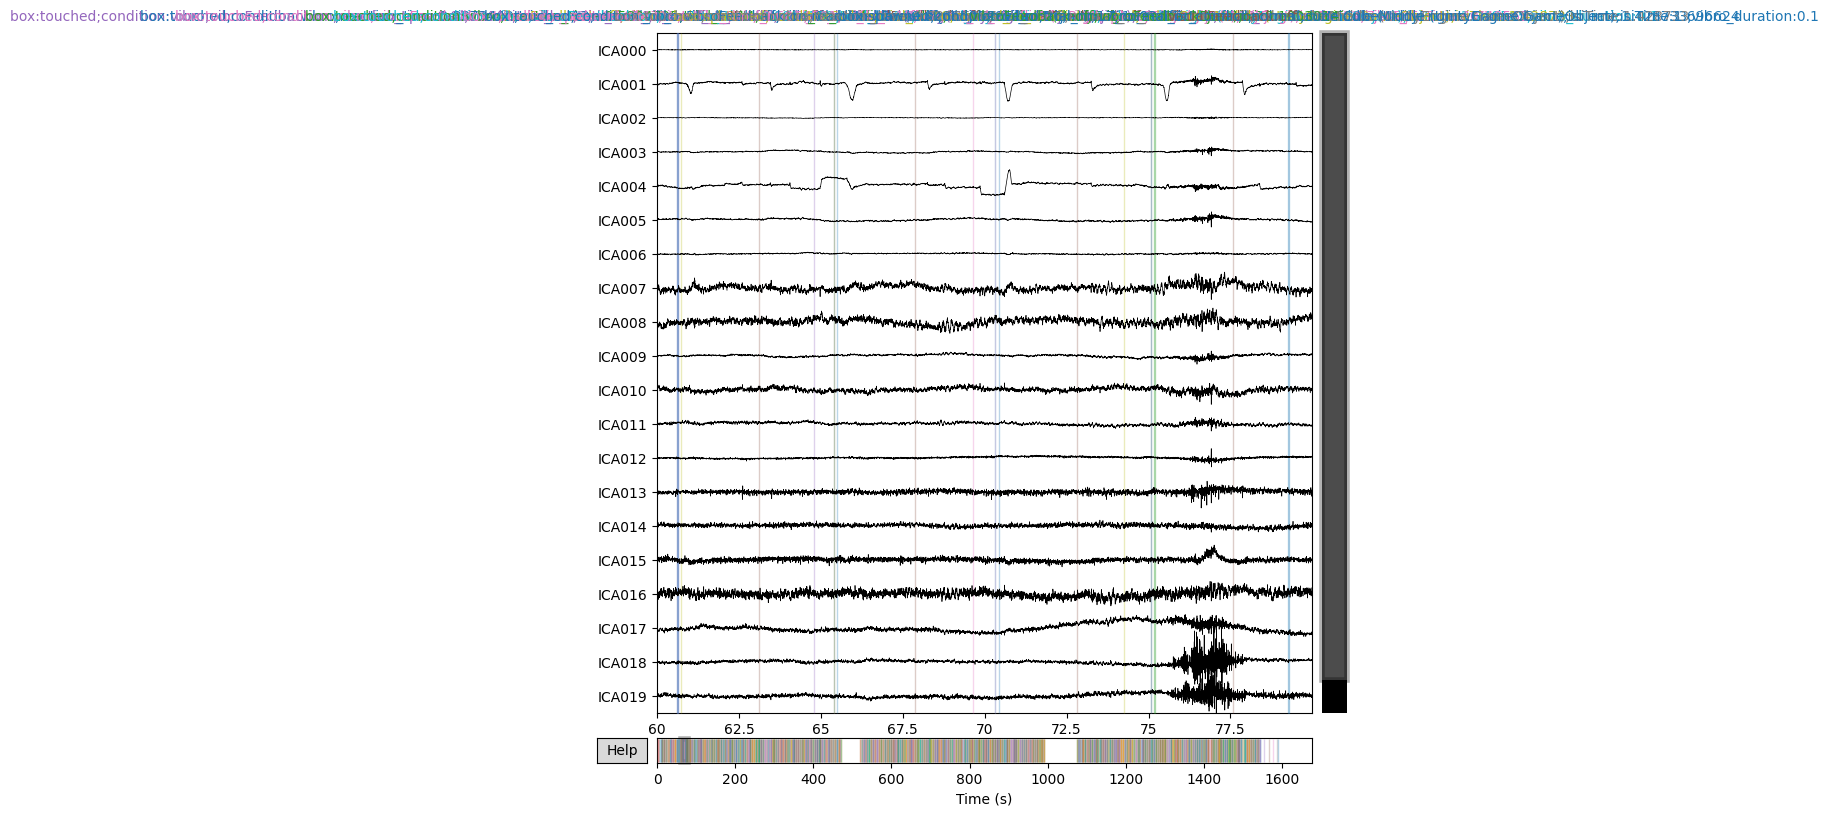

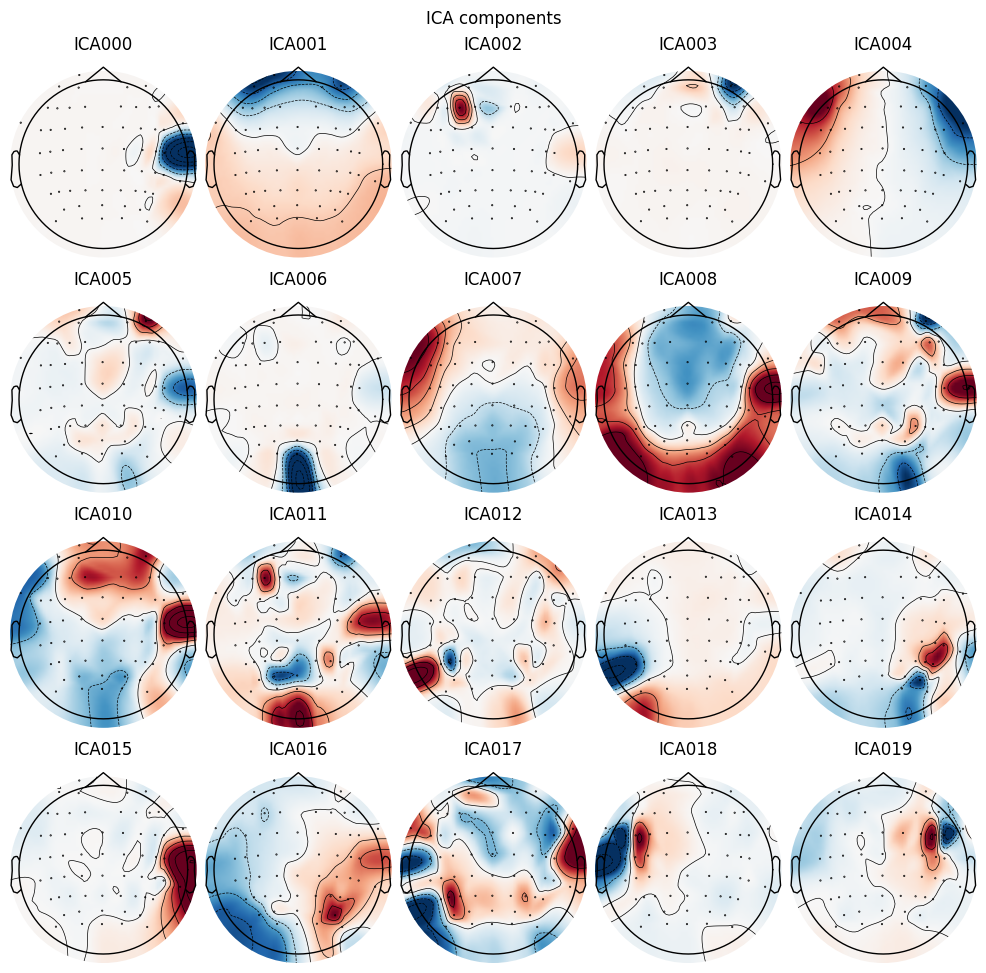

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 62 PCA components


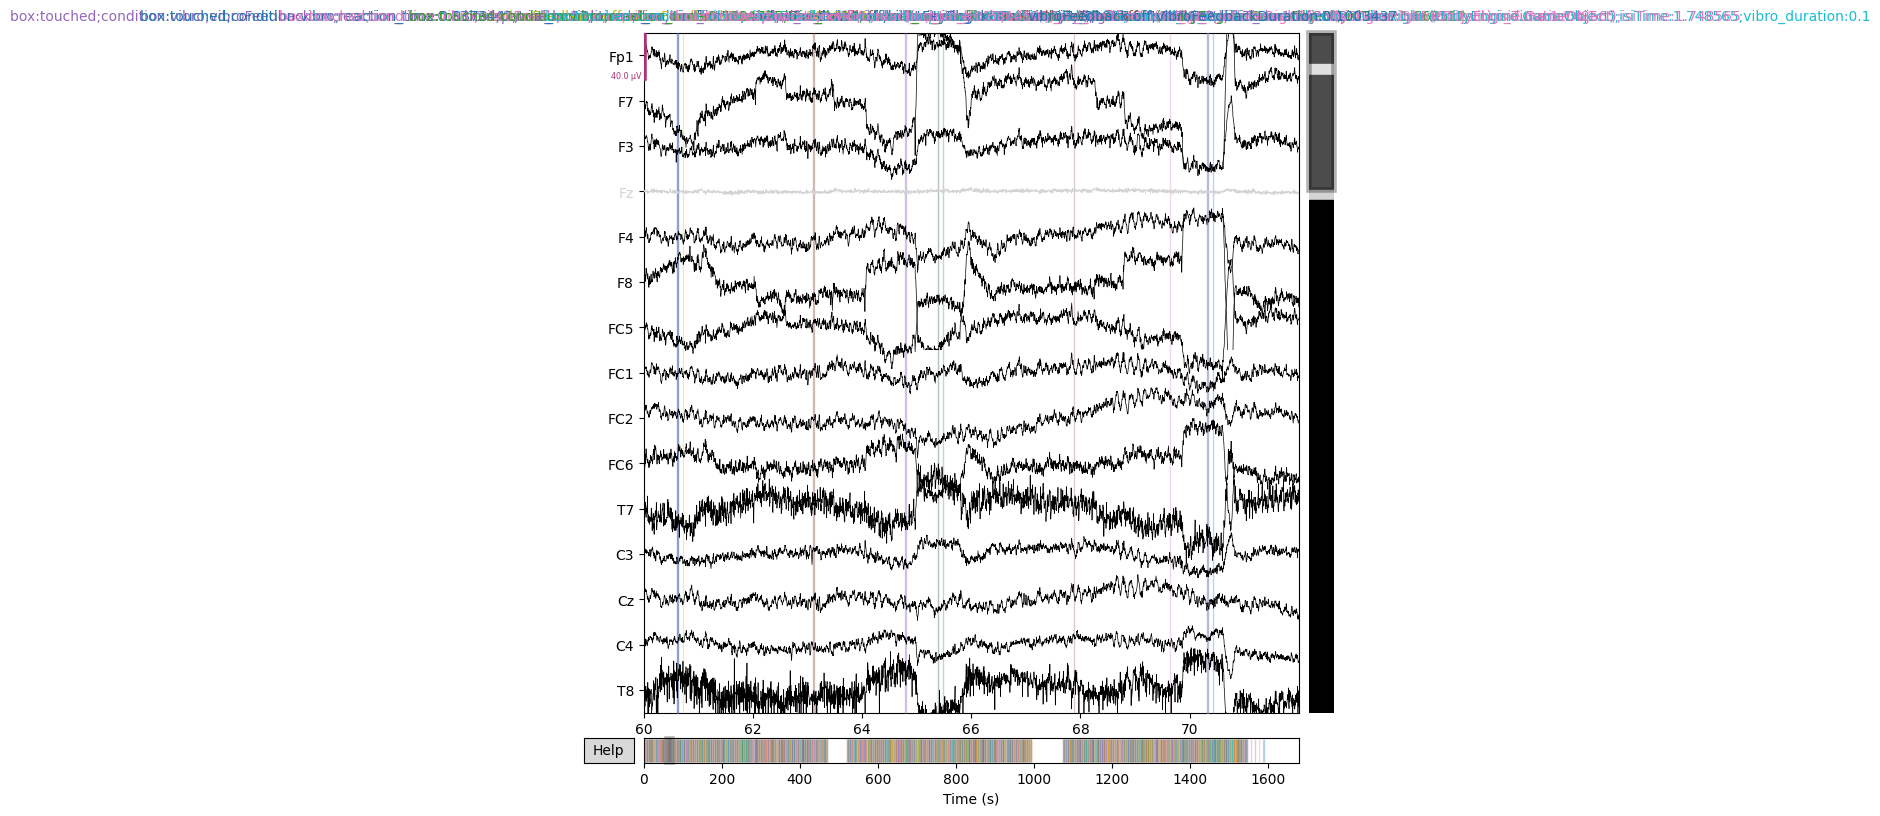

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).
Need more than one channel to make topography for eeg. Disabling interactivity.
Used Annotations descriptions: [np.str_('block:end;currentBlockNr:3;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:2;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:3;condition:vibro;training:false'), np.str_('box:spawned;condition:vibro;trial_nr:100;normal_or_conflict:conflict;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.208381'), np.str_('box:spawned;condition:vibro;trial_nr:101;normal_or_conflict:normal;cube:CubeRight (UnityEngine.GameObject);isiTime:1.771618'), np.str_('box:spawned;condition:vibro;trial_nr:102;normal_or_conflict:normal;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.770561'), np.str_('box:spawned;condition:vibro;trial_nr:103;normal_or_conflict:normal;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.683931'), np.str_('box:spawned;condition:vibro;trial_nr:104;

/Users/jan/miniforge3/envs/eeg/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/var/folders/bb/xxm_9vsj1w9c1jg8lvn4kll00000gn/T/ipykernel_2987/1397405393.py:109: RuntimeWarning: filter_length (1651) is longer than the signal (251), distortion is likely. Reduce filter length or filter a longer signal.
  epochs = epochs.copy().filter(l_freq=0.5, h_freq=35.0)


Need more than one channel to make topography for eeg. Disabling interactivity.


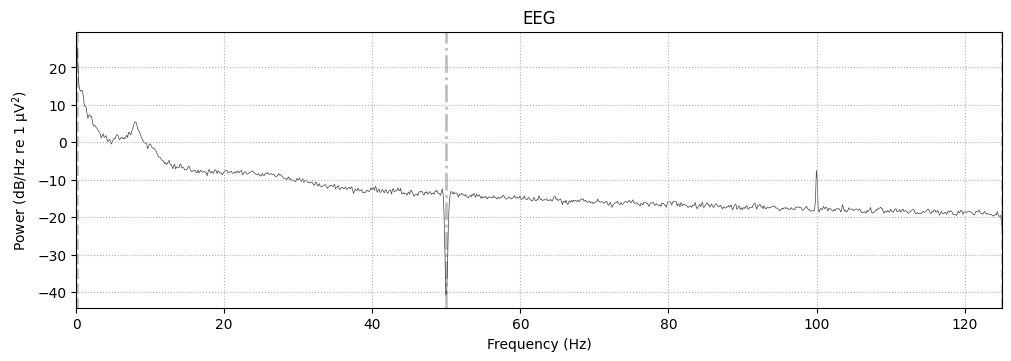

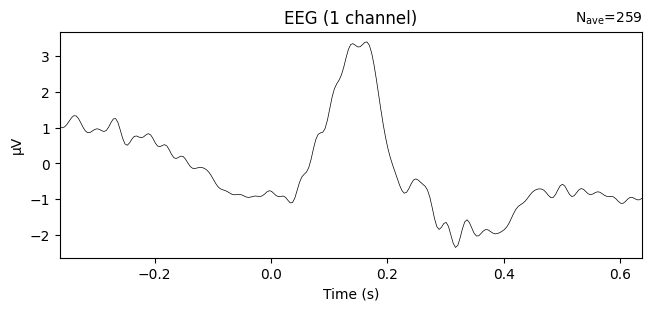

Used Annotations descriptions: [np.str_('block:end;currentBlockNr:3;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:2;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:3;condition:vibro;training:false'), np.str_('box:spawned;condition:vibro;trial_nr:100;normal_or_conflict:conflict;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.208381'), np.str_('box:spawned;condition:vibro;trial_nr:101;normal_or_conflict:normal;cube:CubeRight (UnityEngine.GameObject);isiTime:1.771618'), np.str_('box:spawned;condition:vibro;trial_nr:102;normal_or_conflict:normal;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.770561'), np.str_('box:spawned;condition:vibro;trial_nr:103;normal_or_conflict:normal;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.683931'), np.str_('box:spawned;condition:vibro;trial_nr:104;normal_or_conflict:normal;cube:CubeRight (UnityEngine.GameObject);isiTime:1.005351'), np.str_('box:spawned;condition:vibro;trial_nr:105;normal_or_conflict:co

/var/folders/bb/xxm_9vsj1w9c1jg8lvn4kll00000gn/T/ipykernel_2987/1397405393.py:109: RuntimeWarning: filter_length (1651) is longer than the signal (251), distortion is likely. Reduce filter length or filter a longer signal.
  epochs = epochs.copy().filter(l_freq=0.5, h_freq=35.0)


Need more than one channel to make topography for eeg. Disabling interactivity.


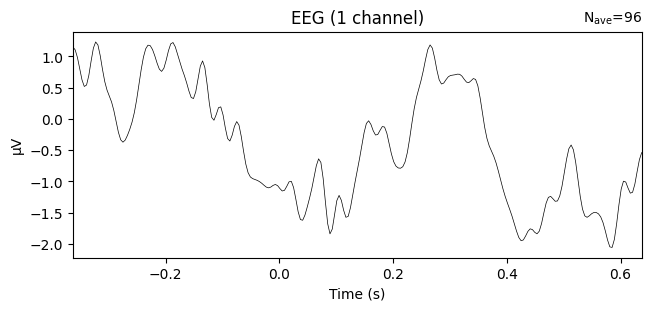

Session: EMS
Extracting parameters from /Users/jan/Documents/git/ds003846/sub-02/ses-EMS/eeg/sub-02_ses-EMS_task-PredictionError_eeg.vhdr...
Setting channel info structure...
Reading events from /Users/jan/Documents/git/ds003846/sub-02/ses-EMS/eeg/sub-02_ses-EMS_task-PredictionError_events.tsv.
Reading channel info from /Users/jan/Documents/git/ds003846/sub-02/ses-EMS/eeg/sub-02_ses-EMS_task-PredictionError_channels.tsv.


/var/folders/bb/xxm_9vsj1w9c1jg8lvn4kll00000gn/T/ipykernel_2987/1397405393.py:10: RuntimeWarning: Unable to map the following column(s) to to MNE:
cap_size: 58
block_1: Visual
block_2: Visual + Vibro
block_3: Visual + Vibro + EMS
  raw = read_raw_bids(bids_path)


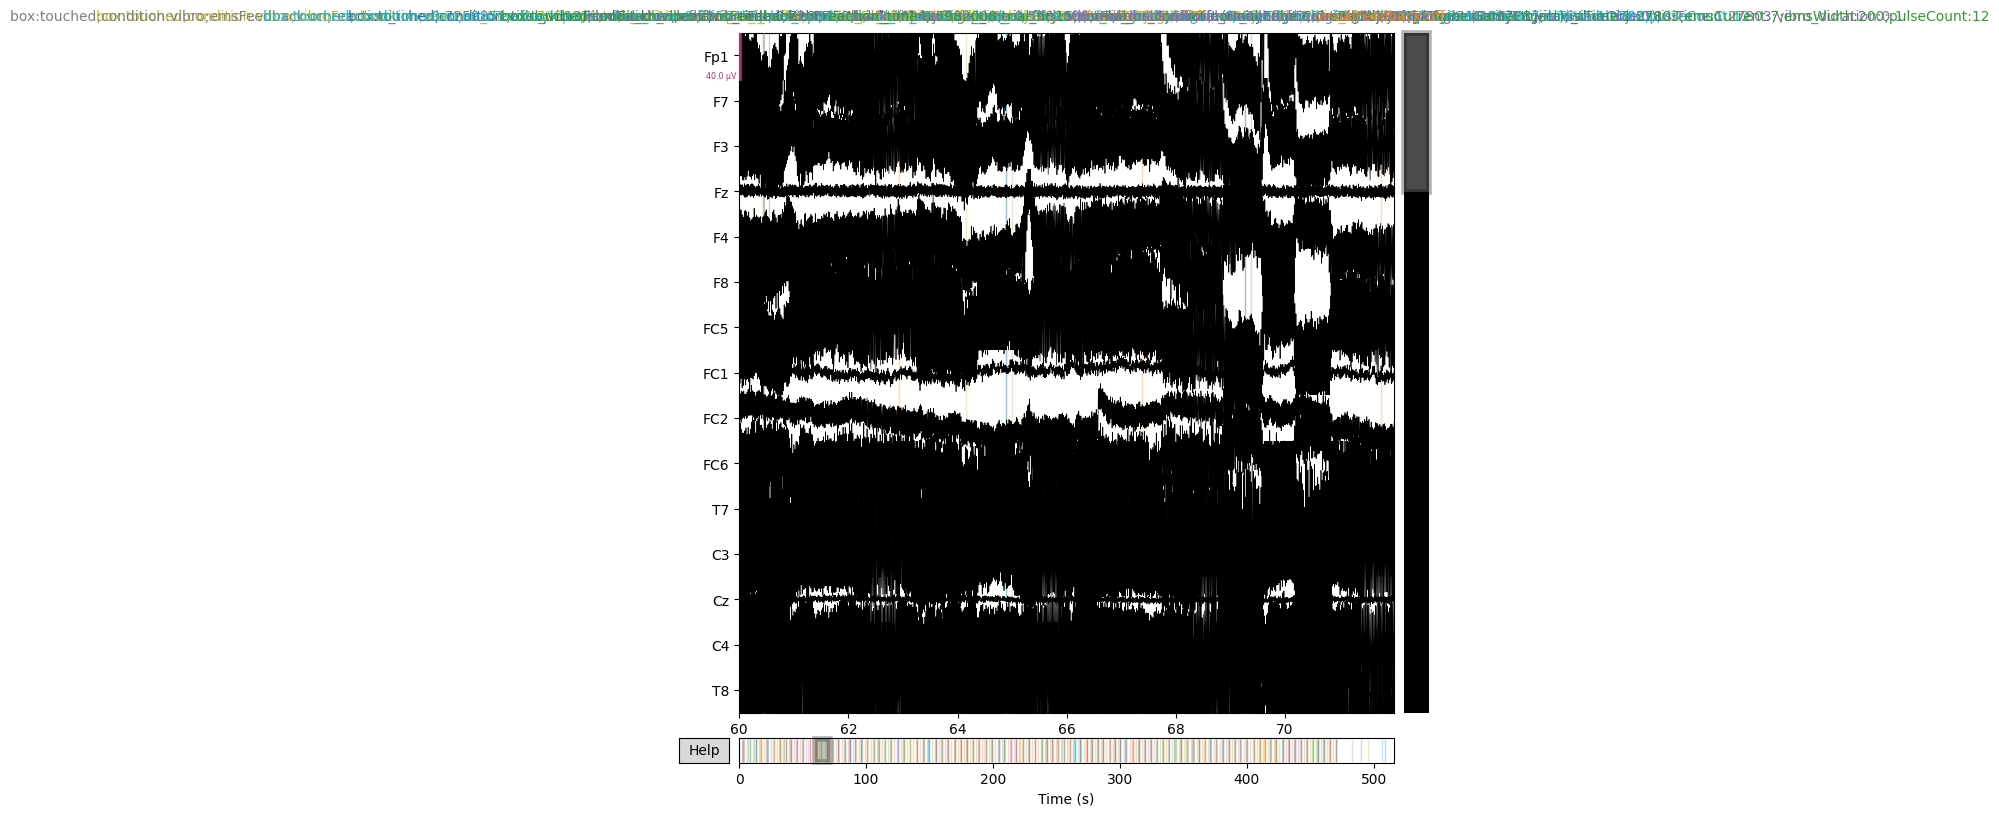

Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Need more than one channel to make topography for eeg. Disabling interactivity.
['Fz', 'TP9']
Reading 0 ... 258029  =      0.000 ...   516.064 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)



/var/folders/bb/xxm_9vsj1w9c1jg8lvn4kll00000gn/T/ipykernel_2987/2655731138.py:13: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  data.copy().pick(["Cz"]).compute_psd().plot()
/Users/jan/miniforge3/envs/eeg/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 125.00 Hz
- Upper transition bandwidth: 31.25 Hz (-6 dB cutoff frequency: 140.62 Hz)
- Filter length: 16501 samples (33.002 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/var/folders/bb/xxm_9vsj1w9c1jg8lvn4kll00000gn/T/ipykernel_2987/1397405393.py:64: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  data.set_montage(montage)


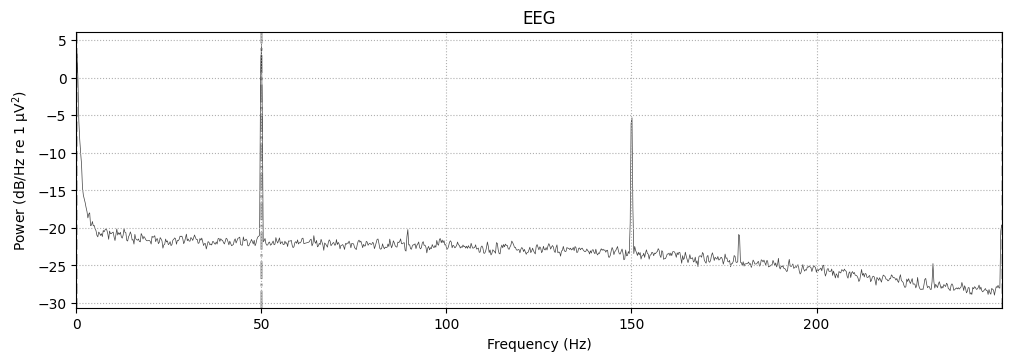

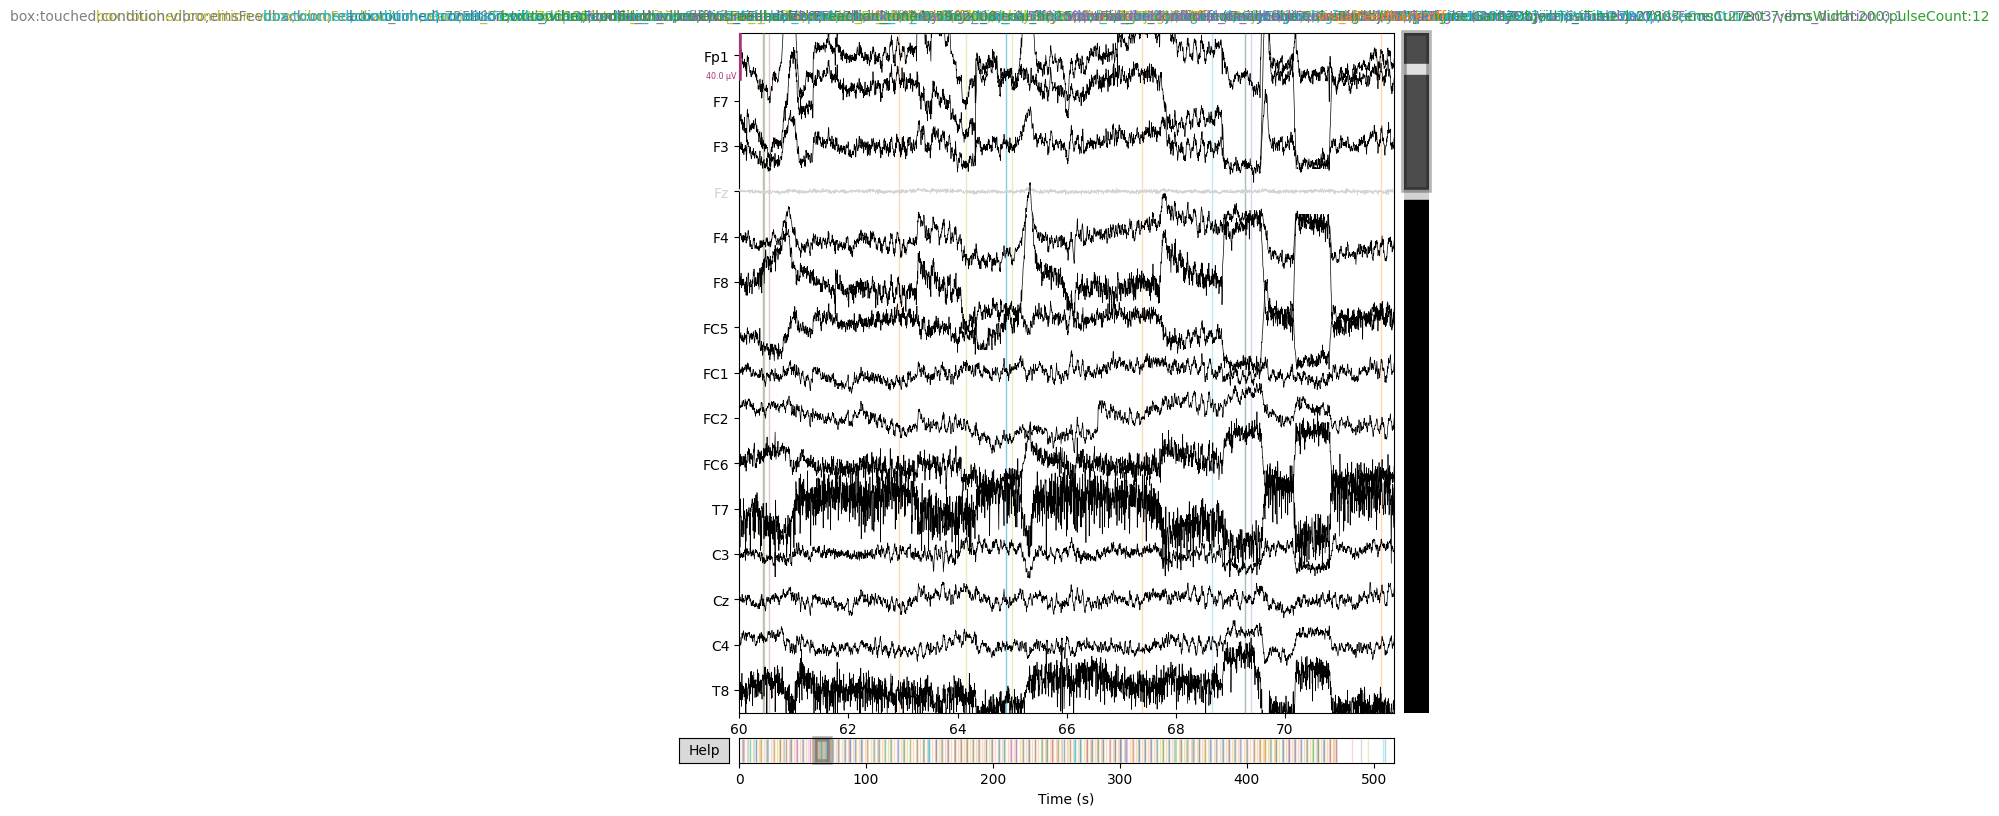

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).
Need more than one channel to make topography for eeg. Disabling interactivity.
Fitting ICA to data using 62 channels (please be patient, this may take a while)


/Users/jan/miniforge3/envs/eeg/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Selecting by number: 20 components
Fitting ICA took 2.0s.
Using EOG channel: Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition

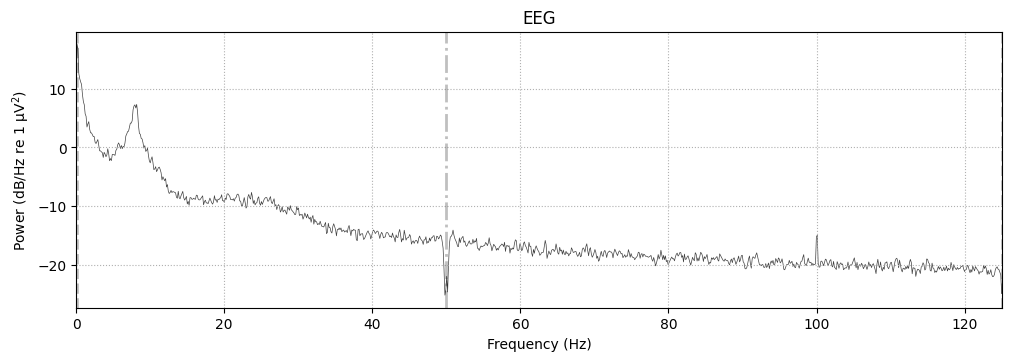

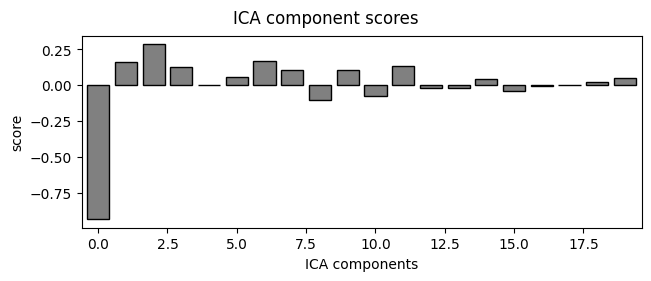

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
258 matching events found
No baseline correction applied
0 projection items activated


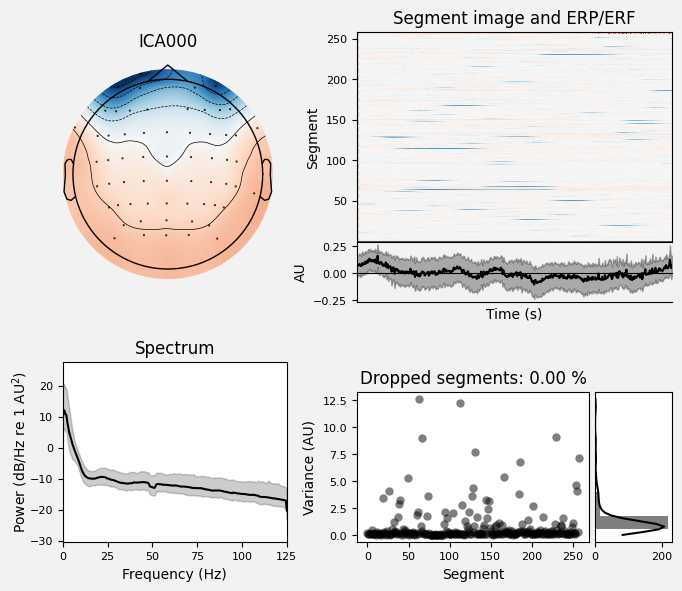

Creating RawArray with float64 data, n_channels=21, n_times=129017
    Range : 0 ... 129016 =      0.000 ...   516.064 secs
Ready.


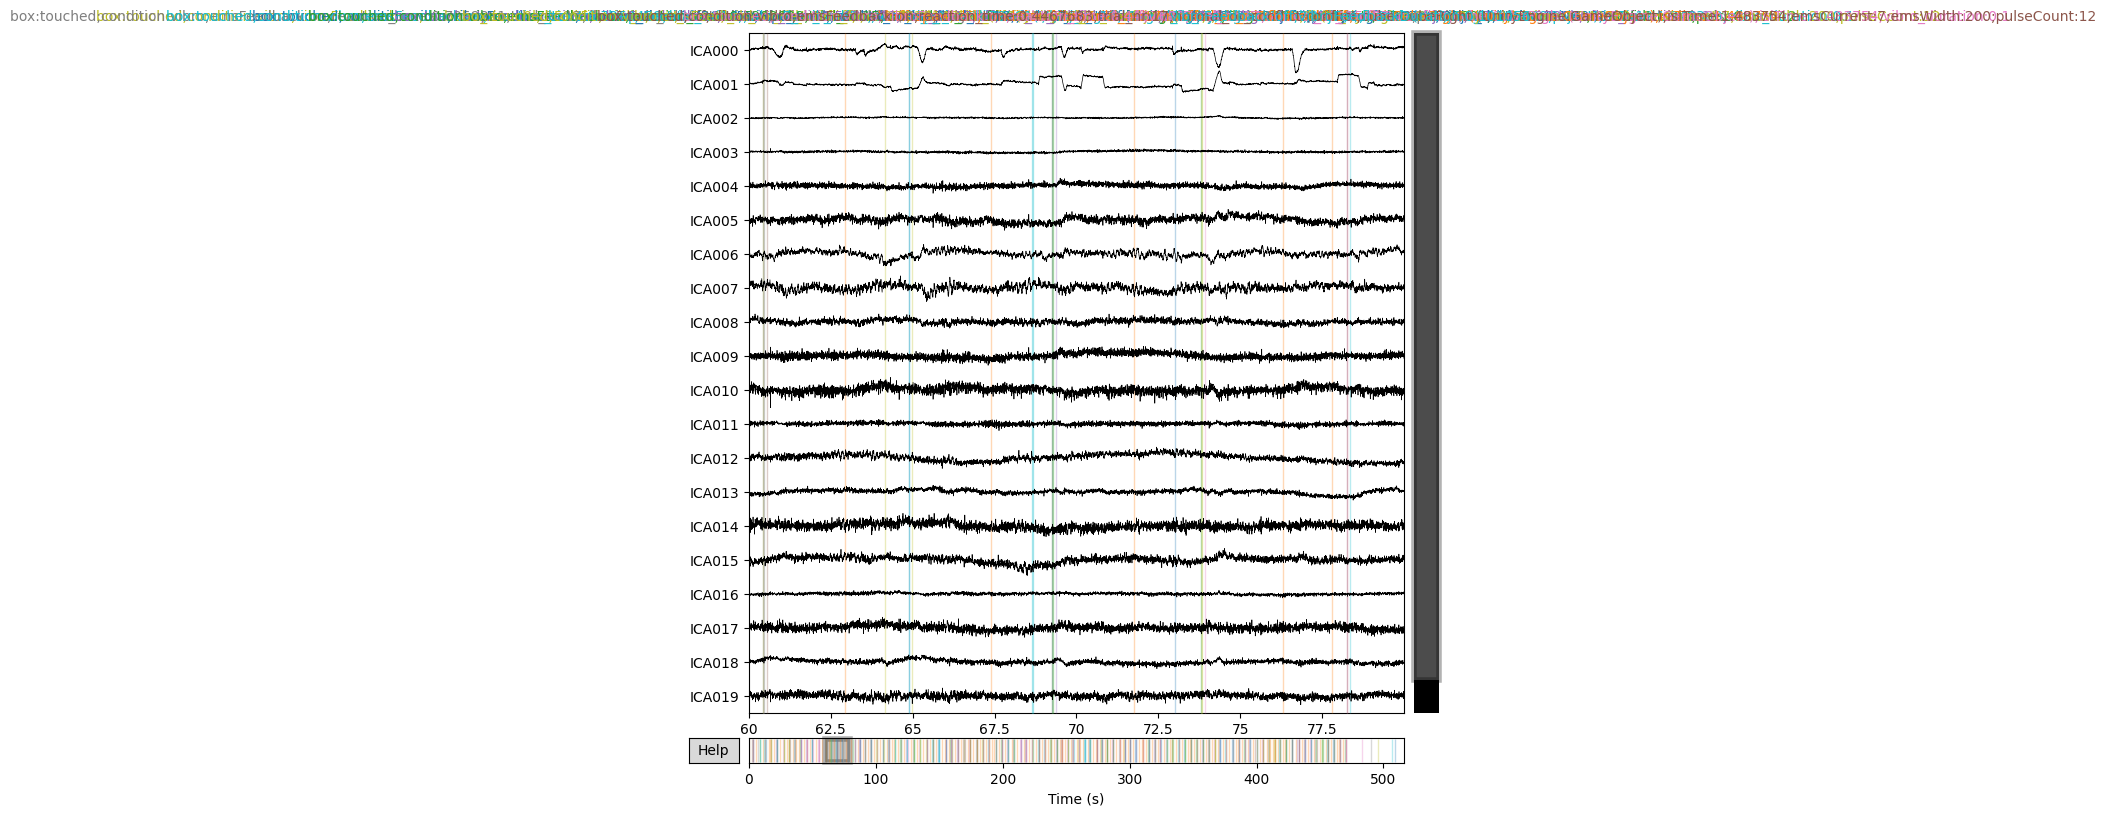

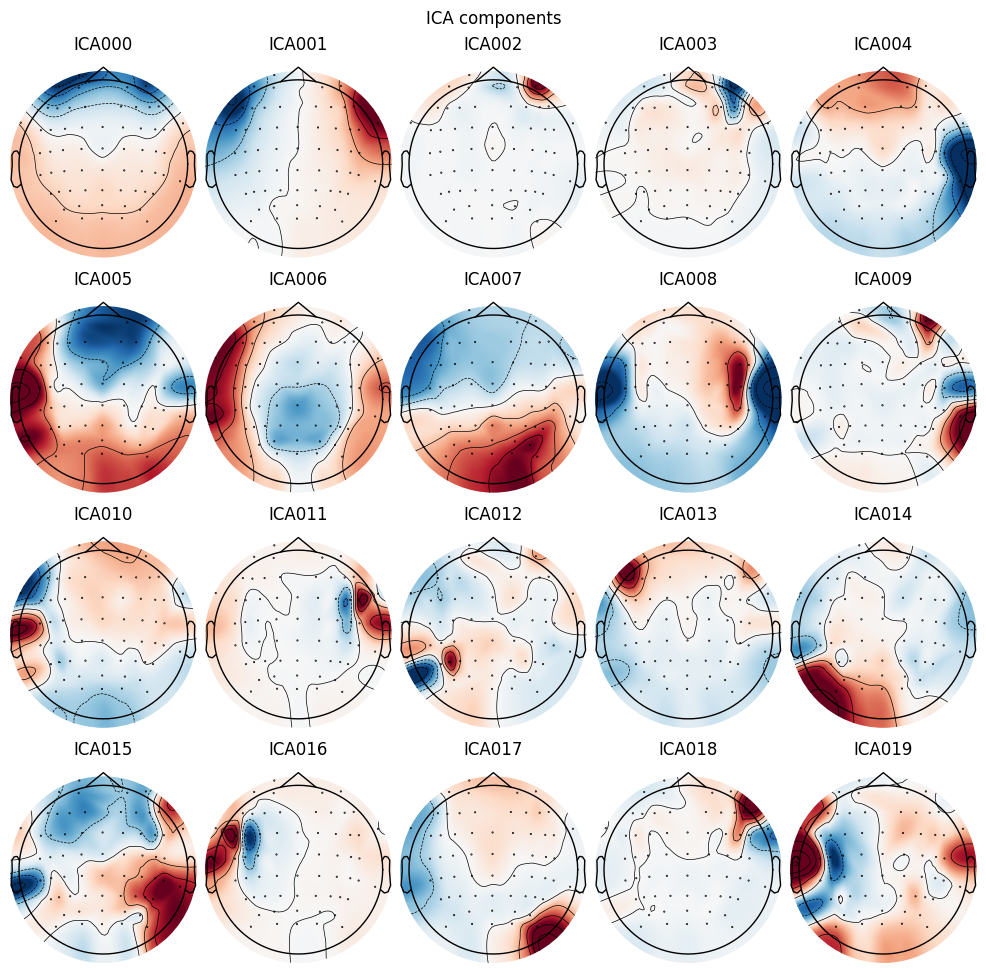

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 62 PCA components


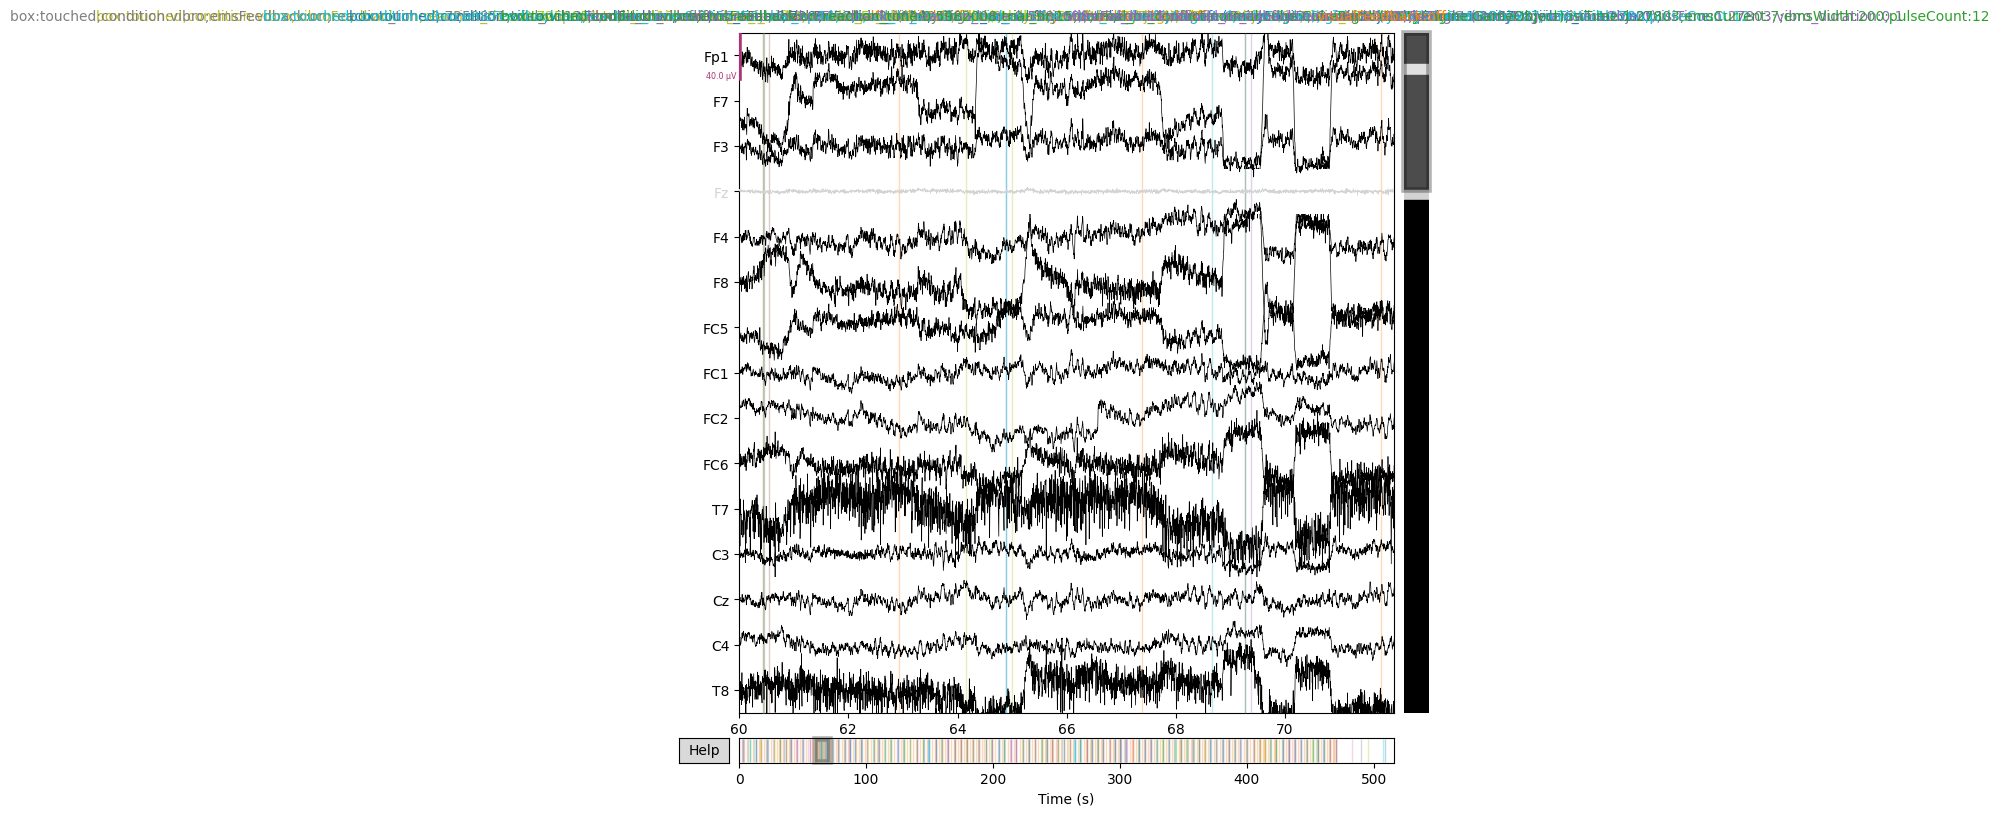

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).
Need more than one channel to make topography for eeg. Disabling interactivity.
Used Annotations descriptions: [np.str_('block:end;currentBlockNr:1;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:1;condition:vibro;training:false'), np.str_('box:spawned;condition:vibro;trial_nr:100;normal_or_conflict:conflict;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.674886'), np.str_('box:spawned;condition:vibro;trial_nr:10;normal_or_conflict:normal;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.224597'), np.str_('box:spawned;condition:vibro;trial_nr:11;normal_or_conflict:conflict;cube:CubeRight (UnityEngine.GameObject);isiTime:1.552389'), np.str_('box:spawned;condition:vibro;trial_nr:12;normal_or_conflict:normal;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.997462'), np.str_('box:spawned;condition:vibro;trial_nr:13;normal_or_conflict:normal;cube:CubeMiddle (UnityEngine.GameObject);isiTime

/Users/jan/miniforge3/envs/eeg/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/var/folders/bb/xxm_9vsj1w9c1jg8lvn4kll00000gn/T/ipykernel_2987/1397405393.py:109: RuntimeWarning: filter_length (1651) is longer than the signal (251), distortion is likely. Reduce filter length or filter a longer signal.
  epochs = epochs.copy().filter(l_freq=0.5, h_freq=35.0)


Need more than one channel to make topography for eeg. Disabling interactivity.


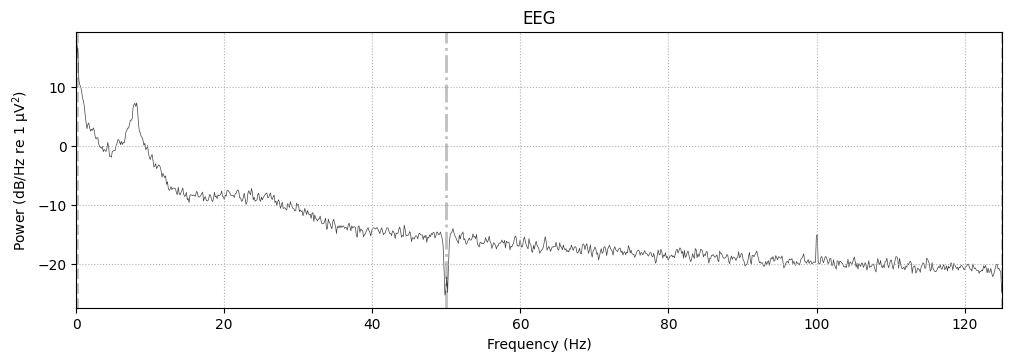

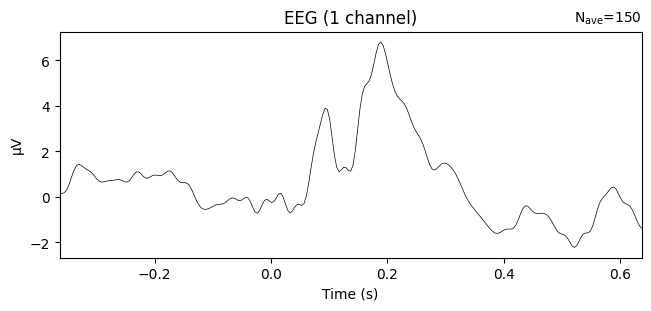

Used Annotations descriptions: [np.str_('block:end;currentBlockNr:1;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:1;condition:vibro;training:false'), np.str_('box:spawned;condition:vibro;trial_nr:100;normal_or_conflict:conflict;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.674886'), np.str_('box:spawned;condition:vibro;trial_nr:10;normal_or_conflict:normal;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.224597'), np.str_('box:spawned;condition:vibro;trial_nr:11;normal_or_conflict:conflict;cube:CubeRight (UnityEngine.GameObject);isiTime:1.552389'), np.str_('box:spawned;condition:vibro;trial_nr:12;normal_or_conflict:normal;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.997462'), np.str_('box:spawned;condition:vibro;trial_nr:13;normal_or_conflict:normal;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.716086'), np.str_('box:spawned;condition:vibro;trial_nr:14;normal_or_conflict:normal;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.209728'), np.str_('b

/var/folders/bb/xxm_9vsj1w9c1jg8lvn4kll00000gn/T/ipykernel_2987/1397405393.py:109: RuntimeWarning: filter_length (1651) is longer than the signal (251), distortion is likely. Reduce filter length or filter a longer signal.
  epochs = epochs.copy().filter(l_freq=0.5, h_freq=35.0)


Need more than one channel to make topography for eeg. Disabling interactivity.


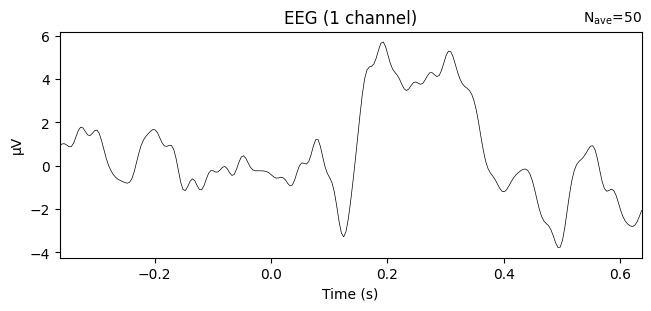

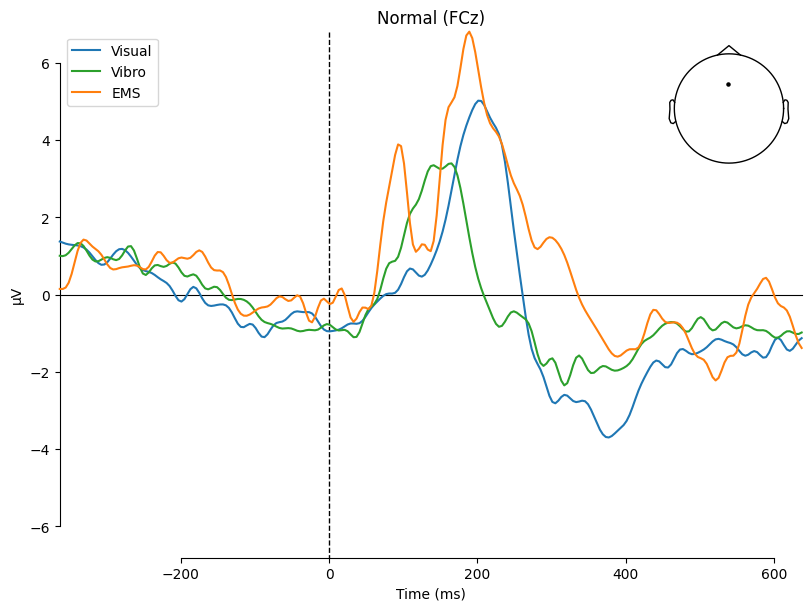

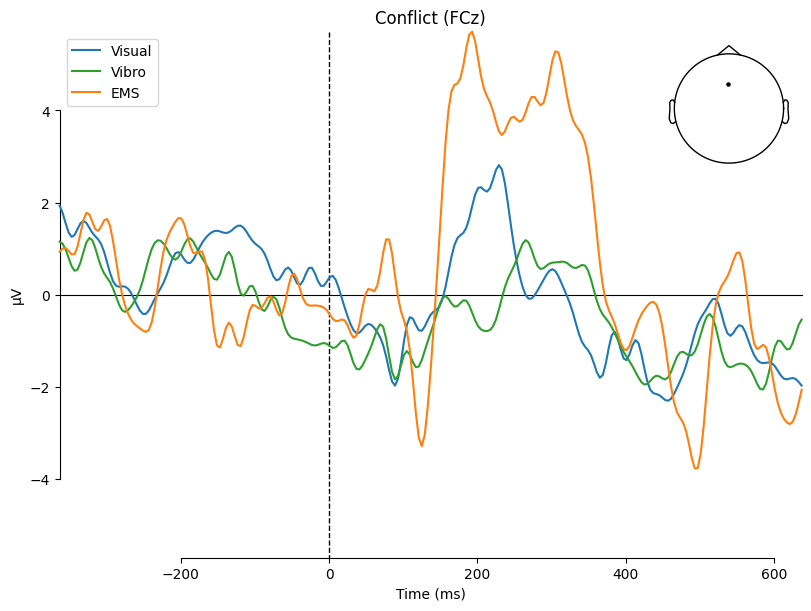

In [199]:
subjects = ["02"]

for subject_id in subjects:
    normal_data = {}
    conflict_data = {}
    for session in ["Visual", "Vibro", "EMS"]:
        print(f"Session: {session}")
        # Load data
        data = load_data(subject_id=subject_id, session=session)
        
        # Plot raw data before and after preprocessing
        data.plot(start=60, duration=12, n_channels=15)
        data.copy().pick(["Cz"]).compute_psd().plot()
        
        # Remove bad channels manually
        remove_bad_channels(data, int(subject_id))

        # Remove bad events manually
        # TBD
        
        # Filtering
        data = filtering_referencing(data)
        
        # Plot better data
        data.plot(start=60, duration=12, n_channels=15)
        data.copy().pick(["Cz"]).compute_psd().plot()
        
        # Apply ICA
        data = apply_ica_eyes(data)
        
        # Plot after ICA
        data.plot(start=60, duration=12, n_channels=15)
        data.copy().pick(["Cz"]).compute_psd().plot()
        
        # Apply ASR to remove remaining artifacts
        # TBD
        
        # ERP
        erp_normal = make_erp(data, condition="normal")
        erp_conflict = make_erp(data, condition="conflict")
        
        normal_data[session] = erp_normal
        conflict_data[session] = erp_conflict
        
    # Plot
    make_erp_plot(normal_data, conflict_data)
